In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [19]:
from google.colab import drive 
drive.mount('/content/gdrive')

PATH = '/content/gdrive/MyDrive/Colab Notebooks/'
PATH_IMG = '/content/gdrive/MyDrive/Colab Notebooks/connected_images/'

Mounted at /content/gdrive


# Предобработка данных

In [32]:
test = pd.read_csv(PATH + 'test.csv')
test_encoded = pd.read_csv(PATH + 'test_encoded.csv')
train = pd.read_csv(PATH + 'train.csv')
train_encoded = pd.read_csv(PATH + 'train_encoded.csv')

data = {'test': test, 'test_encoded': test_encoded, 'train': train, 'train_encoded': train_encoded}

In [ ]:
train.head()

,Unnamed: 0,image_name,type,xmin,xmax,ymin,ymax
0,0,0007Date_01_08_2019.jpg,other,285,368,61,278
1,1,0013Date_01_08_2019.jpg,armature,187,550,101,253
2,2,0016Date_01_08_2019.jpg,armature,172,327,13,360
3,3,0019Date_01_08_2019.jpg,armature,19,267,162,237
4,4,0019Date_01_08_2019.jpg,armature,309,548,300,376


In [ ]:
train_encoded.head()

,Image_name_Type,EncodedPixels
0,0007Date_01_08_2019.jpg_armature,1 1
1,0007Date_01_08_2019.jpg_other,43229 83 43933 83 44637 83 45341 83 46045 83 4...
2,0007Date_01_08_2019.jpg_wood,1 1
3,0013Date_01_08_2019.jpg_armature,71291 363 71995 363 72699 363 73403 363 74107 ...
4,0013Date_01_08_2019.jpg_other,1 1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2541 entries, 0 to 2540
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2541 non-null   int64 
 1   image_name  2541 non-null   object
 2   type        2541 non-null   object
 3   xmin        2541 non-null   int64 
 4   xmax        2541 non-null   int64 
 5   ymin        2541 non-null   int64 
 6   ymax        2541 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 139.1+ KB


In [ ]:
print("В тестовом наборе {} объектов \nВ обучающем наборе {} объектов".format(len(test), len(train)))

В тестовом наборе 1688 объектов 
В обучающем наборе 2541 объектов


## Размер изображений

In [33]:
# посмотрим на размер исходных изображений (вдруг что-то нужно будет нормаировать)
# добавим в таблицу новый признак - размер изображения

pic_size = set()

test_img_size = []
train_img_size = []

for key in ['train', 'test']:
  for i, row in data[key].iterrows():
    im = cv2.imread(PATH_IMG + row['image_name'])
    height, width, _ = im.shape
    pic_size.add((height, width))
    if key == 'train':
      train_img_size.append((height, width))
    else:
      test_img_size.append((height, width))

train['Size'] = train_img_size
test['Size'] = test_img_size

print(pic_size)
test.head()

{(576, 704), (421, 704)}


,Unnamed: 0,image_name,type,xmin,xmax,ymin,ymax,Usage,Size
0,0,0000Date_01_08_2019.jpg,armature,173,403,84,380,Public,"(421, 704)"
1,1,0029Date_01_08_2019.jpg,armature,54,307,29,346,Public,"(421, 704)"
2,2,0049Date_01_08_2019.jpg,armature,510,576,71,202,Public,"(421, 704)"
3,3,0054Date_01_08_2019.jpg,armature,124,213,1,102,Public,"(421, 704)"
4,4,0057Date_01_08_2019.jpg,armature,158,579,80,278,Public,"(421, 704)"


In [34]:
#посмотрим сколько каких размеров

size_table_train = train.groupby(['Size'])['Size'].count().reset_index(name='Count')
size_table_train

,Size,Count
0,"(421, 704)",2541


In [35]:
size_table_test = test.groupby(['Size'])['Size'].count().reset_index(name='Count')
size_table_test

,Size,Count
0,"(421, 704)",1686
1,"(576, 704)",2


Получается в тестовом наборе данных присутствуют два изображения с нетипичным размером.

Удалим эти объекты

In [36]:
len_before = len(test)
test = test.loc[test['Size'] != (576, 704)]
len_after = len(test)
print("удалено {} объекта".format(len_before-len_after))

удалено 2 объекта


## Проверка пропусков

In [ ]:
def check_empty(table):
  headers = table.columns
  count_null = pd.DataFrame(table[headers].isnull().sum())
  count_null = count_null.reset_index()
  count_null.rename(columns = {'index' : 'Column', 0 : 'Count_null'}, inplace = True) 
  
  return count_null

In [ ]:
for key in data:
  print(key + ':')
  print(check_empty(data[key]), '\n\n')

test:
       Column  Count_null
0  Unnamed: 0           0
1  image_name           0
2        type           0
3        xmin           0
4        xmax           0
5        ymin           0
6        ymax           0
7       Usage           0 


test_encoded:
            Column  Count_null
0  Image_name_Type           0
1    EncodedPixels           0
2            Usage           0 


train:
       Column  Count_null
0  Unnamed: 0           0
1  image_name           0
2        type           0
3        xmin           0
4        xmax           0
5        ymin           0
6        ymax           0 


train_encoded:
            Column  Count_null
0  Image_name_Type           0
1    EncodedPixels           0 




Пропусков нет

## Работа с признаками

In [ ]:
# посмотрим на варианты целевого признака
target = train['type'].unique()
print(target)

['other' 'armature' 'wood']


Варианты целевого признака:
- **other**
- **armature**
- **wood**

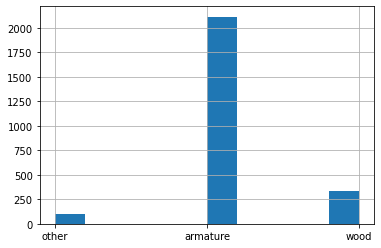

In [37]:
# посмотрим на количество целевых признаков в обучающей выборке

h = train['type'].hist()
fig = h.get_figure()

Выборка не сбалансирована

In [ ]:
# у меня вызывают подозрения данные с EncodedPixels = 1 1 => 
# посмотрим на значения этого признака

temp = train_encoded.groupby(['EncodedPixels'])['EncodedPixels'].count().reset_index(name='Count')
temp[temp['Count'] > 1]

,EncodedPixels,Count
1,1 1,4540


Получается, в тренировочной выборке 4540 объекта имеют странное значение признака *EncodedPixels* = "1 1"

## Выделение объектов

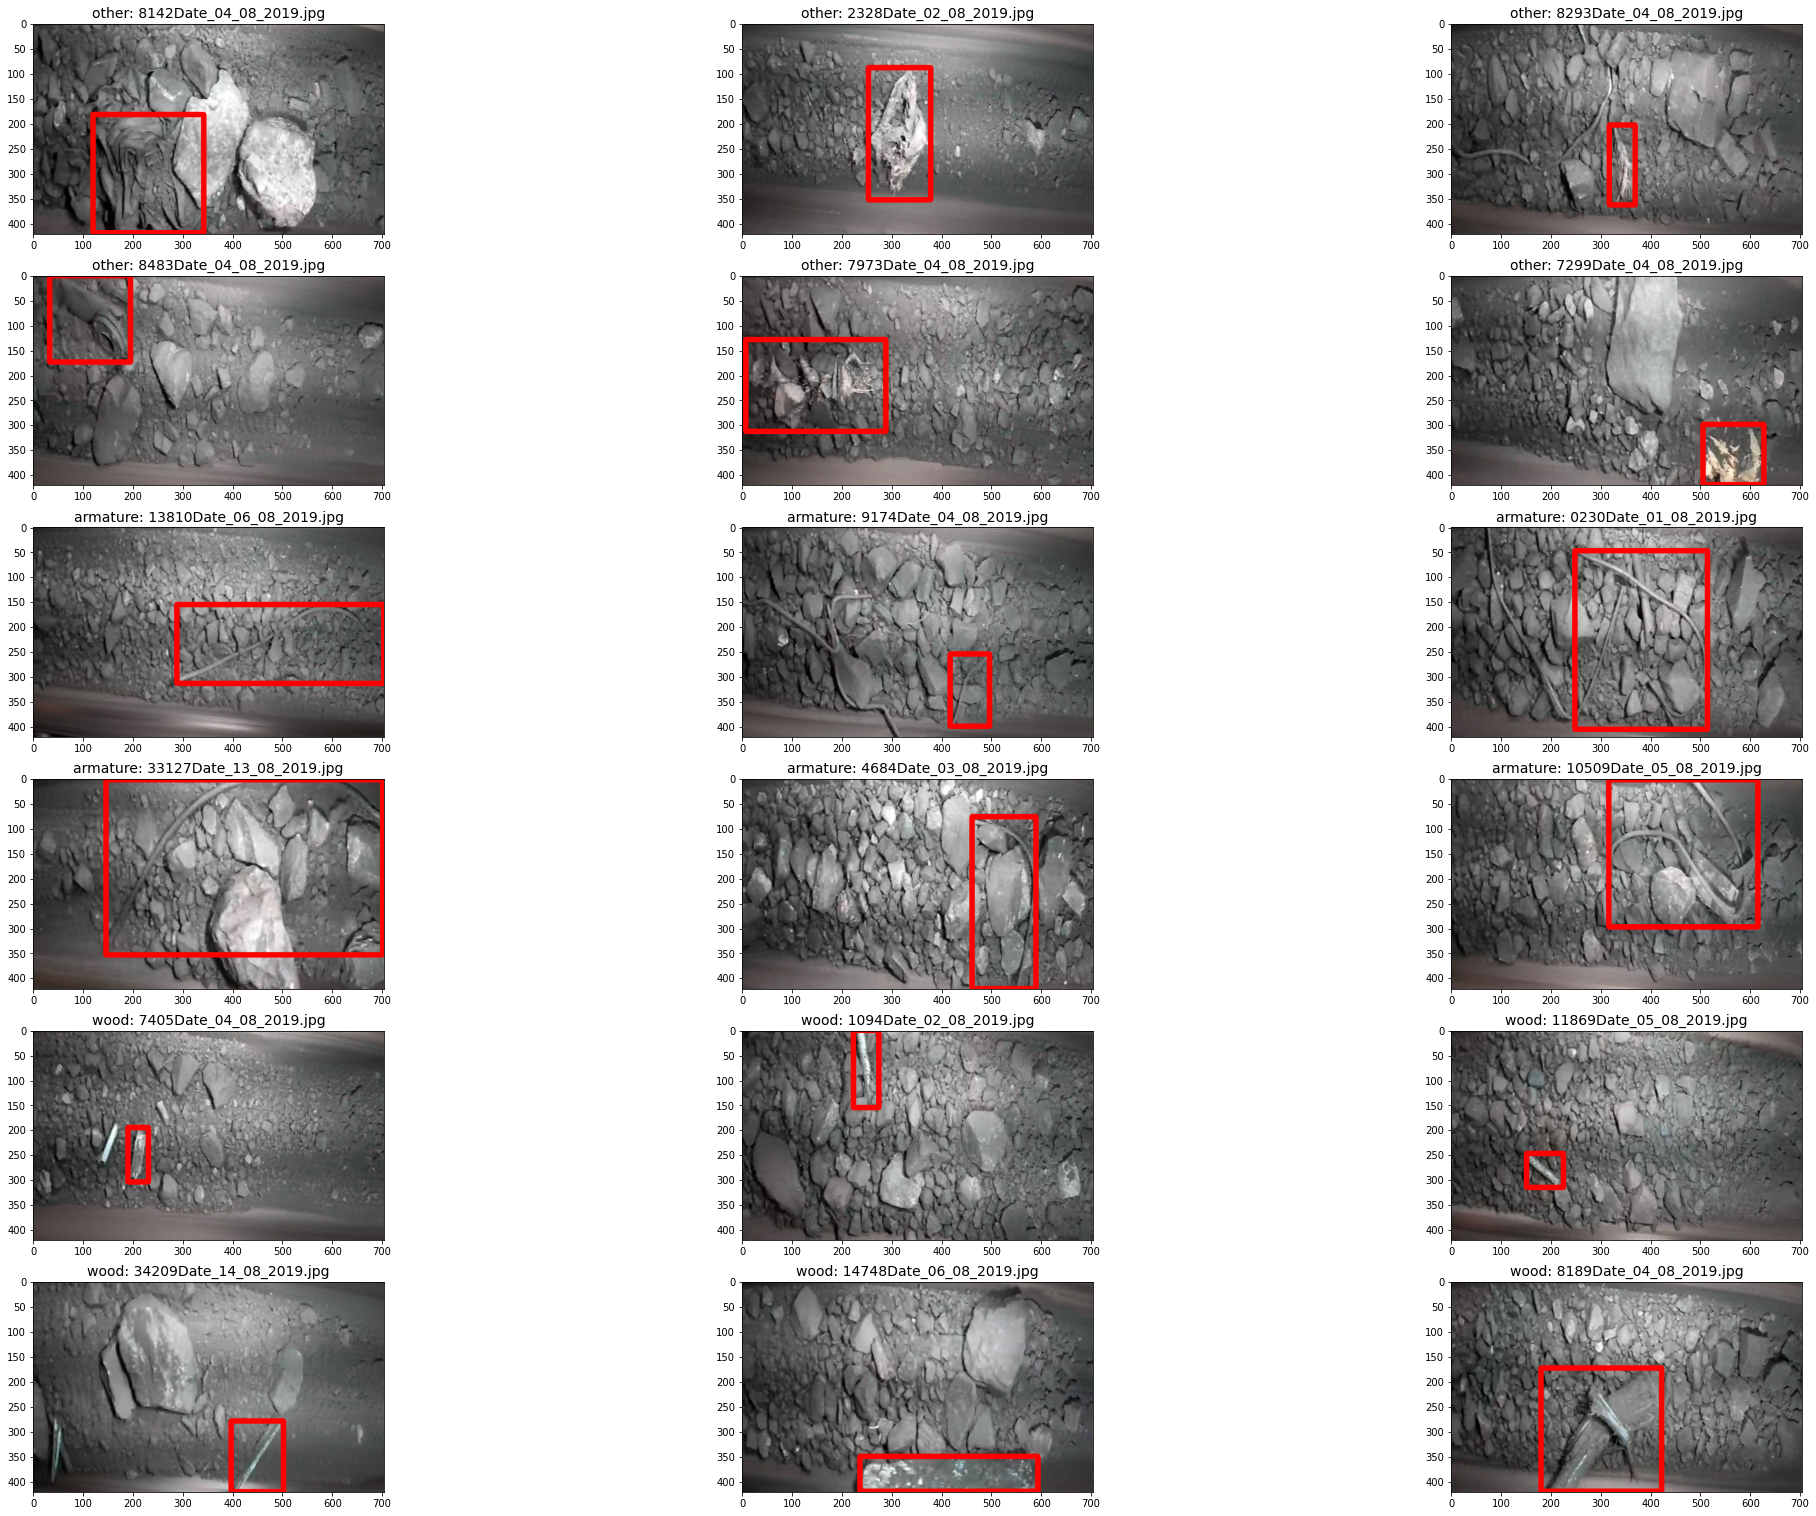

In [ ]:
# посмотрим, как выделялись объекты на изображениях
# cv2.rectangle(image, start_point, end_point, color, thickness)

other = train[train['type'] == 'other'].sample(n=6)
armature = train[train['type'] == 'armature'].sample(n=6)
wood = train[train['type'] == 'wood'].sample(n=6)

samples = {'other': other, 'armature': armature, 'wood': wood}

fig = plt.figure(figsize=(36, 27))
t = 1
for key in samples:
  for i, row in samples[key].iterrows():
    ax = fig.add_subplot(6, 3, t)
    ax.set_title(key + ': ' + row['image_name'], fontsize=14)
    im = cv2.imread(PATH_IMG + row['image_name'])
    x_min, x_max, y_min, y_max = row['xmin'], row['xmax'], row['ymin'], row['ymax']
    rec = cv2.rectangle(im, (x_min, y_min), (x_max, y_max), (255, 0, 0), 10)
    ax.imshow(rec, cmap='bone')
    t+=1